<a href="https://colab.research.google.com/github/anishjohnson/NYC_Taxi_TripTime_Prediction/blob/main/NYC_Taxi_TripDuration_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### **Data fields**
* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* trip_duration - duration of the trip in seconds

# **Import libraries and data.**

In [ ]:
# import the libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error


import datetime as dt
from seaborn import palettes


import warnings
warnings.filterwarnings("ignore")

# We will use haverseine to calculate the distance using the longitudinal and lattitue data.
!pip install haversine
from haversine import haversine

In [ ]:
# Mount the drive.
from google.colab import drive
drive.mount('/content/drive/')

# Load the data.
df = pd.read_csv('/content/drive/MyDrive/Capstone data files/NYC Taxi Data.csv')

# Create a copy of data to be on the safer side.
nyc_df = df.copy()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **Exploratory Data Analysis.**

In [ ]:
nyc_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
nyc_df.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198


In [ ]:
# Check the shape of our data.
shape = nyc_df.shape
print(f'The dataset contains {shape[0]} rows and {shape[1]} columns.')

The dataset contains 1458644 rows and 11 columns.


In [ ]:
# Check if it contains null values.
nyc_df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [ ]:
# Only originals needed, remove the duplicates.
duplicates = nyc_df.duplicated().sum()

if duplicates == 0:
  print('No duplicates exist we are good to go.👌')
else:
  print(duplicates,'exist remove them.')

No duplicates exist we are good to go.👌


In [ ]:
# Reveal information about the data.
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [ ]:
# Get some statiscis.
nyc_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


***Points to be noted:***
* *id can be dropped - as every ride would have different id it would'nt give any useful insight.*
* *pickup_datetime and dropoff_time need to be changed to datetime format - currently they are in string (object) format.*
* *extract data from datetime values.*
* *duration is given in seconds lets convert it into minutes.*
* *store_and_fwd_flag is a categorical variable that needs to be converted.*
* *vendor_id consists of two values 1 and 2.*
* *passenger_count ranges from 0-9, the difference between the 75th percentile and the max value shows the precense of outliers.*
* *trip_duration_minutes also contains outliers.*

In [ ]:
# Drop id.
# nyc_df.drop('id', inplace=True, axis=1)

In [ ]:
# Change format for pickup_datetime and dropoff_time.
nyc_df['pickup_datetime'] = pd.to_datetime(nyc_df['pickup_datetime'])
nyc_df['dropoff_datetime'] = pd.to_datetime(nyc_df['dropoff_datetime'])

In [ ]:
# Retrive day and month data.
nyc_df['day'] = nyc_df.pickup_datetime.dt.weekday
nyc_df['month'] = nyc_df.pickup_datetime.dt.month

# Retrive pickup and dropoff hrs.
nyc_df['pickup_hour'] = nyc_df.pickup_datetime.dt.hour
nyc_df['dropoff_hour'] = nyc_df.dropoff_datetime.dt.hour

In [ ]:
# Now lets drop pickup_datetime and dropoff_datetime as we have extracted data from it.
nyc_df.drop(['pickup_datetime', 'dropoff_datetime'], inplace=True, axis=1)

In [ ]:
# Convert the data from seconds to mins.
nyc_df['trip_duration_minutes']=nyc_df['trip_duration']/60

# Drop duration in seconds.
nyc_df.drop('trip_duration', inplace=True, axis=1)

In [ ]:
# Recheck if formats been changed.
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 13 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   id                     1458644 non-null  object 
 1   vendor_id              1458644 non-null  int64  
 2   passenger_count        1458644 non-null  int64  
 3   pickup_longitude       1458644 non-null  float64
 4   pickup_latitude        1458644 non-null  float64
 5   dropoff_longitude      1458644 non-null  float64
 6   dropoff_latitude       1458644 non-null  float64
 7   store_and_fwd_flag     1458644 non-null  object 
 8   day                    1458644 non-null  int64  
 9   month                  1458644 non-null  int64  
 10  pickup_hour            1458644 non-null  int64  
 11  dropoff_hour           1458644 non-null  int64  
 12  trip_duration_minutes  1458644 non-null  float64
dtypes: float64(5), int64(6), object(2)
memory usage: 144.7+ MB


***Now lets bring in the charts and diagrams for better understanding.***  *😊*

## **Dependent Variable.**

In [ ]:
nyc_df['trip_duration_minutes'].describe()

count    1.458644e+06
mean     1.599154e+01
std      8.729053e+01
min      1.666667e-02
25%      6.616667e+00
50%      1.103333e+01
75%      1.791667e+01
max      5.877137e+04
Name: trip_duration_minutes, dtype: float64

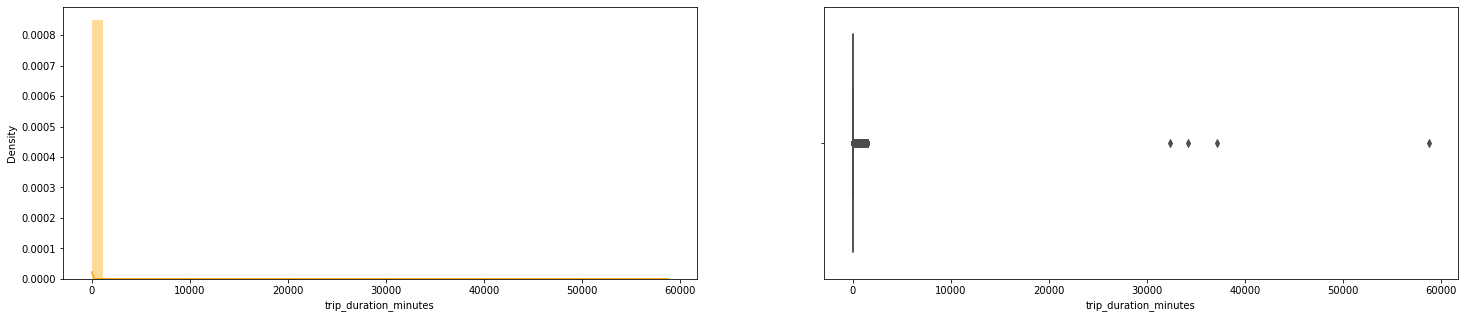

In [ ]:
# Check out the trip_duration.
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,5))
# plt.figure(figsize=(10,5))
sns.distplot(nyc_df['trip_duration_minutes'], color='orange', ax=ax1)
sns.boxplot(nyc_df['trip_duration_minutes'], color='orange', ax=ax2)
plt.show()

* ***trip_duration_minutes is positively skewed.***
* ***also it seems there are few extreme values that we will need to check.***

In [ ]:
nyc_df[nyc_df['trip_duration_minutes'] > 10000]

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day,month,pickup_hour,dropoff_hour,trip_duration_minutes
355003,id1864733,1,1,-73.789650,40.643559,-73.956810,40.773087,N,1,1,0,11,32328.933333
680594,id0369307,1,2,-73.921677,40.735252,-73.984749,40.759979,N,5,2,22,15,34159.633333
924150,id1325766,1,1,-73.983788,40.742325,-73.985489,40.727676,N,1,1,6,1,37126.866667
978383,id0053347,1,1,-73.783905,40.648632,-73.978271,40.750202,N,5,2,22,18,58771.366667


* ***Now that we look at the extreme values these are more than 20 days, which was either due to some technical error or a vaccation was planned.***
* ***Since there are only four values and these could only cause problems for our model lets remove these values.***

In [ ]:
# Get rid of the extreme values.
nyc_df = nyc_df[nyc_df['trip_duration_minutes'] < 10000]

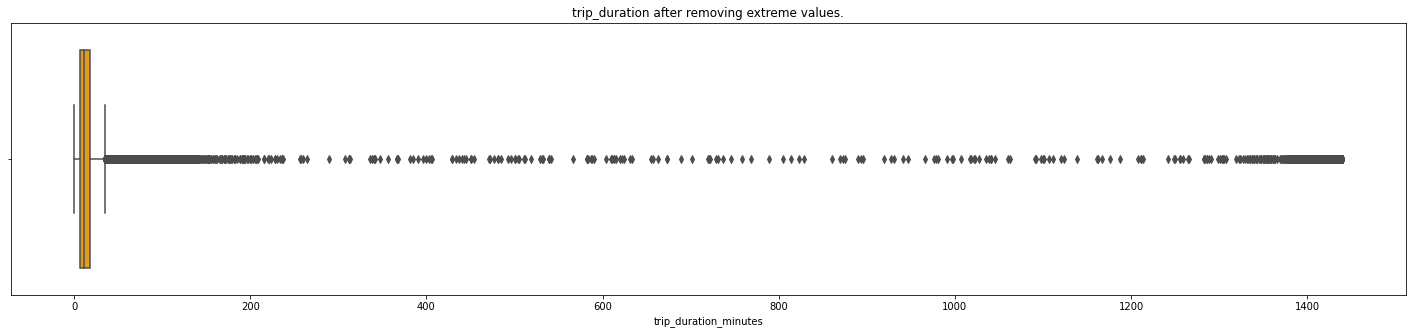

In [ ]:
# Now lets check for outliers in the dependent variables.
fig = plt.figure(figsize=(25,5))
sns.boxplot(nyc_df['trip_duration_minutes'], color='orange')
plt.title('trip_duration after removing extreme values.')
plt.show()

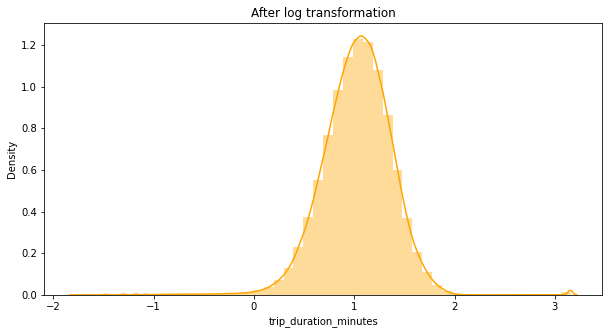

In [ ]:
# Apply log transformation and plot it.
plt.figure(figsize=(10,5))
plt.title('After log transformation')
sns.distplot(np.log10(nyc_df['trip_duration_minutes']), color='orange')
plt.show()

* ***log transformation has solved the problem of skewness*** 
* ***but there are few values which maybe outliers, this could be bad for our model.***
* ***lets look into this ahead in our analysis.***

## **Independent Variables.**

In [ ]:
nyc_df.head(1)

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day,month,pickup_hour,dropoff_hour,trip_duration_minutes
0,id2875421,2,1,-73.982155,40.767937,-73.96463,40.765602,N,0,3,17,17,7.583333


In [ ]:
independent_variables = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                         'dropoff_latitude', 'store_and_fwd_flag', 'day', 'month', 'pickup_hour', 'dropoff_hour']

**vendor_id.**

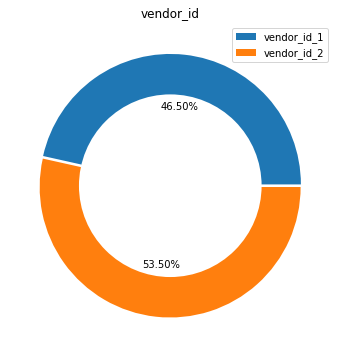

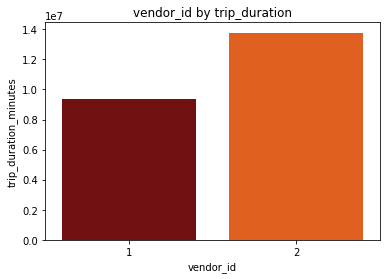

In [ ]:
# Calculate the trips done by each vendor.
one = len(nyc_df[nyc_df['vendor_id'] == 1])
two = len(nyc_df[nyc_df['vendor_id'] == 2])
v_id = [one, two]
v_name = ['vendor_id_1', 'vendor_id_2']

# Plot it.
fig = plt.figure(figsize=(6,6))
plt.pie(v_id, autopct='%1.2f%%', explode=(0.01,0.01))
plt.title('vendor_id')
plt.legend(labels=v_name)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.show()

# Groupby trip duration
durationByvendor = nyc_df.groupby('vendor_id', as_index=False)['trip_duration_minutes'].sum()
sns.barplot(data=durationByvendor, x='vendor_id', y='trip_duration_minutes', palette='gist_heat')
plt.title('vendor_id by trip_duration')
plt.show()

* ***53.50% of the trips are completed by the vendor 2 and 46.50% of the trips are completed by vendor 1.***
* ***also maximum duration is covered by vendor 2***

.

**passenger_count.**

In [ ]:
nyc_df['passenger_count'].describe()

count    1.458640e+06
mean     1.664531e+00
std      1.314244e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

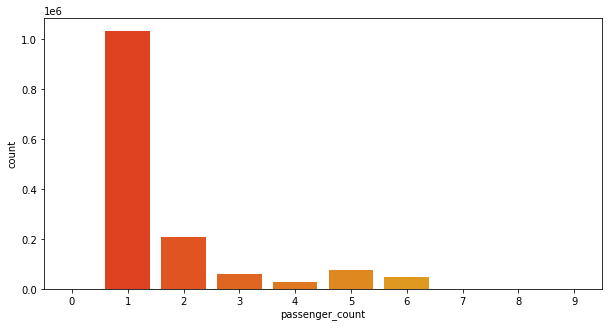

In [ ]:
# Passenger count.
plt.figure(figsize=(10,5))
sns.countplot(nyc_df['passenger_count'], palette='autumn')
plt.show()

* ***some values are zero which mean either the trip was cancled or there was an error in the data entry.***
* ***7, 8, 9 are extreme cases considering the capacity of a car, so we will get rid of them.***
* ***most of the trips (75%) contain atmost 1 or 2 passengers.***

**Remove unwanted values from passenger_count.**

In [ ]:
# Remove the extreme values from passenger_count.
nyc_df = nyc_df[nyc_df['passenger_count'] <= 6]  # This will remove passenger values with 7,8,9 values.

In [ ]:
# Remove values which are zero.
nyc_df = nyc_df[nyc_df.passenger_count != 0]

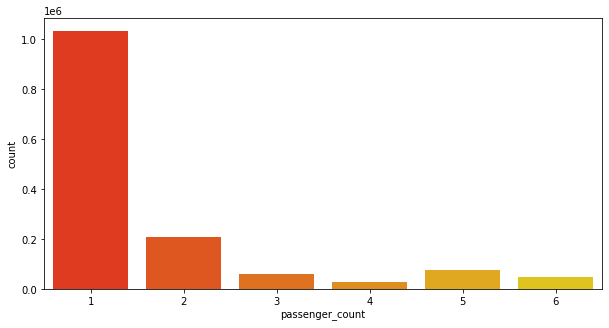

In [ ]:
# Plot it.
plt.figure(figsize=(10,5))
sns.countplot(nyc_df['passenger_count'], palette='autumn')
plt.show()

***Looks good*** *👍*

.

**pickup/dropoff latitude and longitude.**

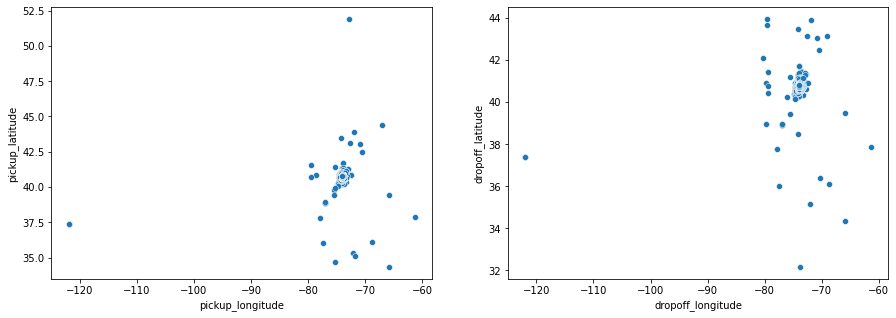

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
sns.scatterplot(nyc_df['pickup_longitude'], nyc_df['pickup_latitude'], ax=ax1)
sns.scatterplot(nyc_df['dropoff_longitude'], nyc_df['dropoff_latitude'], ax=ax2)
plt.show()

***Lets check whats with those extreme values.***

In [ ]:
nyc_df[nyc_df['pickup_longitude'] < -120]

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day,month,pickup_hour,dropoff_hour,trip_duration_minutes
1068810,id3777240,2,2,-121.933235,37.389297,-121.933205,37.389103,N,2,1,18,18,18.416667
1184454,id2854272,2,2,-121.933342,37.389381,-121.933304,37.389511,N,4,2,13,13,8.316667


In [ ]:
nyc_df[nyc_df['pickup_latitude'] > 50]

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day,month,pickup_hour,dropoff_hour,trip_duration_minutes
184925,id2306955,1,1,-72.809669,51.881084,-73.987228,40.750599,N,5,5,18,19,13.2


In [ ]:
nyc_df[nyc_df['dropoff_longitude'] < -120]

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day,month,pickup_hour,dropoff_hour,trip_duration_minutes
1068810,id3777240,2,2,-121.933235,37.389297,-121.933205,37.389103,N,2,1,18,18,18.416667
1184454,id2854272,2,2,-121.933342,37.389381,-121.933304,37.389511,N,4,2,13,13,8.316667


In [ ]:
nyc_df[nyc_df['dropoff_latitude'] < 34]

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day,month,pickup_hour,dropoff_hour,trip_duration_minutes
275644,id0978162,1,4,-75.354332,34.712234,-73.834923,32.181141,N,2,2,16,16,14.583333


***Lets drop these values.***

In [ ]:
nyc_df = nyc_df[nyc_df.id != 'id3777240']
nyc_df = nyc_df[nyc_df.id != 'id2854272']
nyc_df = nyc_df[nyc_df.id != 'id2306955']
nyc_df = nyc_df[nyc_df.id != 'id0978162']

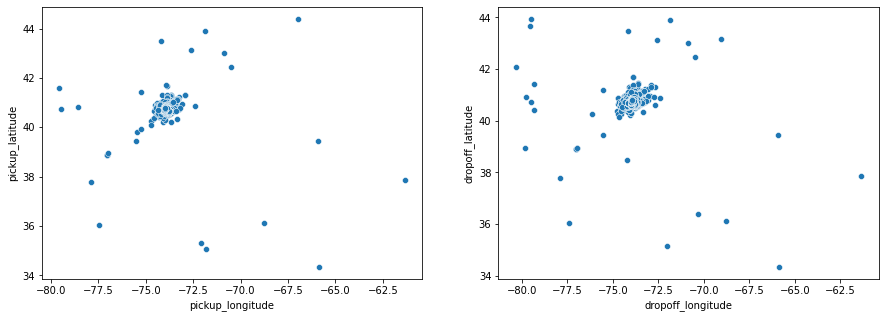

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
sns.scatterplot(nyc_df['pickup_longitude'], nyc_df['pickup_latitude'], ax=ax1)
sns.scatterplot(nyc_df['dropoff_longitude'], nyc_df['dropoff_latitude'], ax=ax2)
plt.show()

***It looks better now.***

.

**store_and_fwd_flag.**

In [ ]:
nyc_df['store_and_fwd_flag'].describe()

count     1458571
unique          2
top             N
freq      1450529
Name: store_and_fwd_flag, dtype: object

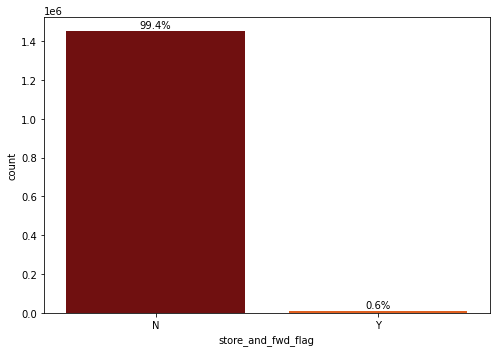

In [ ]:
# Plot it.
fig = plt.figure(figsize=(7,5))
plot = sns.countplot(nyc_df['store_and_fwd_flag'], palette='gist_heat')

total = len(nyc_df)
for p in plot.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plot.annotate(percentage, (x, y), ha='center', va='center')

plt.tight_layout()
plt.show()

* ***99.4% of the data values are N and only 0.6% 0f values are Y, which means most of the data was uploaded directly without storing it and forwarding.***
* ***this ia a categorical feature which we will be converting into numeric by getting dummies.***

.

**day/month	and pickup_hour/dropoff_hour**

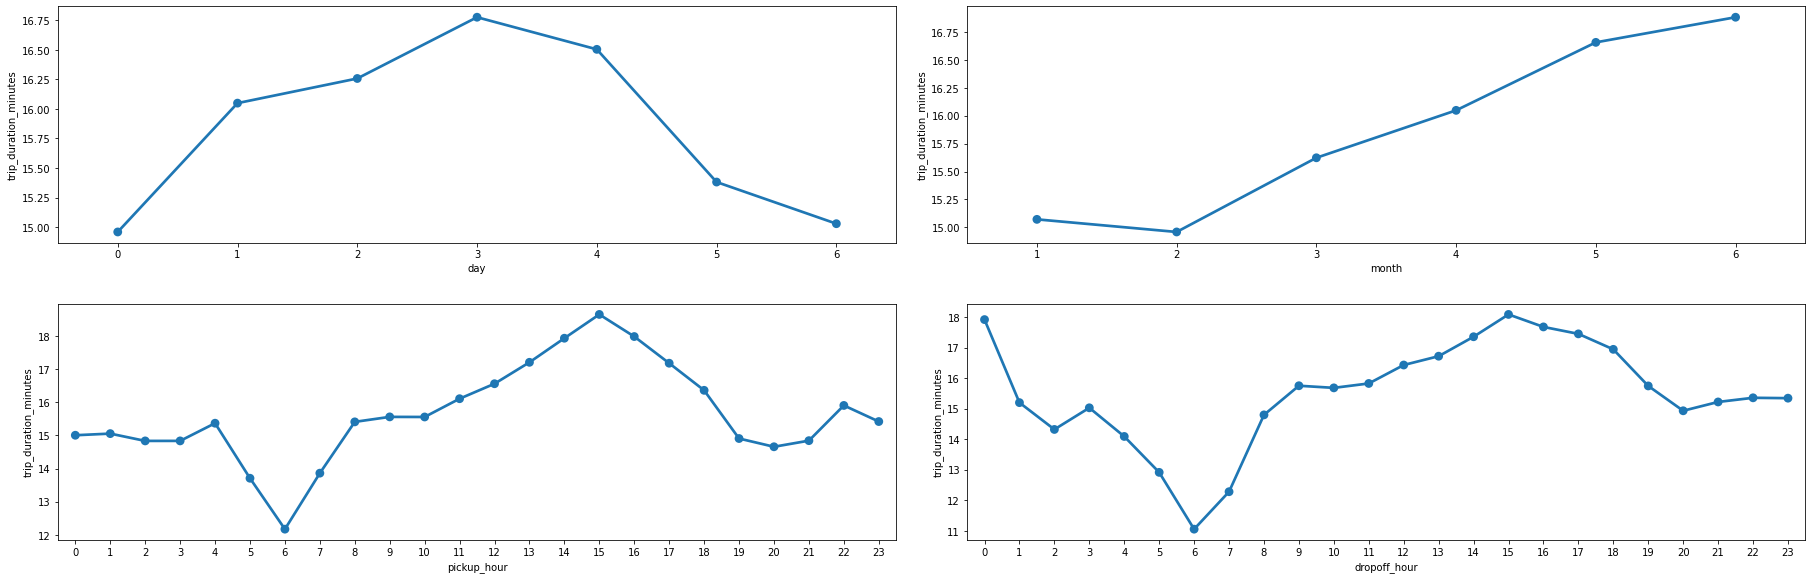

In [ ]:
# Now lets get some visuals from the above data.
fig, ax = plt.subplots(2,2, figsize=(25,8))
fig.tight_layout(h_pad=4, w_pad=4)
sns.pointplot(data=nyc_df, x='day', y='trip_duration_minutes', ax=ax[0][0], ci=None)
sns.pointplot(data=nyc_df, x='month', y='trip_duration_minutes', ax=ax[0][1], ci=None)
sns.pointplot(data=nyc_df, x='pickup_hour', y='trip_duration_minutes', ax=ax[1][0], ci=None)
sns.pointplot(data=nyc_df, x='dropoff_hour', y='trip_duration_minutes', ax=ax[1][1], ci=None)
plt.show()

* ***trip duration decreases as the weekend approches, it makes sense as most of the people either stay at home or go for vacations.***
* ***trip duration increases after Feburary, this might be due to the people returning after holidays***.
* ***pickup and dropoff hours are almost the same, most of the comute happen from 6am to 7pm after which it gradually decreases.***

.

# **Data Cleaning And Feature Engineering.**

***First lets remove outliers from our dependent variable.***

In [ ]:
# Create a function to get upper and lower bounds for removing outliers.
def outlier_treatment(feature):
  sorted(feature)
  Q1,Q3 = np.percentile(feature , [25,75])
  IQR = Q3 - Q1
  lower_range = Q1 - (1.5 * IQR)
  upper_range = Q3 + (1.5 * IQR)
  return lower_range,upper_range

In [ ]:
# Get upper/lower bounds for trip_duration.
lowerbound,upperbound = outlier_treatment(nyc_df['trip_duration_minutes'])
print(lowerbound,upperbound)

nyc_df[(nyc_df['trip_duration_minutes'] < lowerbound) | (nyc_df['trip_duration_minutes'] > upperbound)]

-10.333333333333336 34.866666666666674


,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day,month,pickup_hour,dropoff_hour,trip_duration_minutes
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,N,1,1,11,12,35.400000
16,id3379579,2,1,-73.991165,40.755562,-73.999290,40.725353,N,0,4,17,18,38.600000
24,id3321406,2,1,-73.955231,40.777134,-73.788750,40.641472,N,4,6,8,8,41.416667
29,id1410897,1,1,-73.982117,40.756351,-73.865692,40.770988,N,2,3,14,14,38.850000
33,id0023813,1,1,-73.990311,40.756580,-73.870918,40.773930,N,6,4,14,15,37.816667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458571,id1440046,1,2,-73.778946,40.647343,-73.952103,40.781166,N,6,6,22,23,40.900000
1458584,id1607338,2,1,-73.786697,40.641628,-73.996880,40.732506,N,1,6,20,21,38.916667
1458589,id2071901,1,2,-73.782280,40.644783,-73.904305,40.738285,N,4,6,16,17,34.883333
1458600,id0995846,2,2,-73.789543,40.647099,-73.960320,40.798180,N,0,5,17,18,63.683333


In [ ]:
nyc_df.drop(nyc_df[ (nyc_df['trip_duration_minutes'] > upperbound) | (nyc_df['trip_duration_minutes'] < lowerbound) ].index , inplace=True)

.

**Lets calculate distance travelled using pickup and dropoff data.**

In [ ]:
# Function to calculate distance using the haversine function as we are provided with gps data.
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [ ]:
# Get distances.
nyc_df['distance'] = nyc_df.apply(lambda x: calc_distance(x), axis = 1)

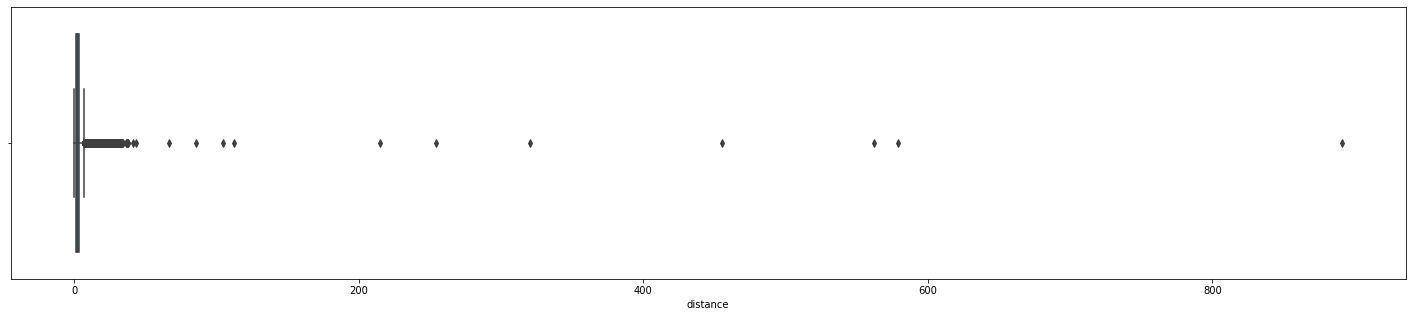

In [ ]:
# Get plots.
fig = plt.figure(figsize=(25,5))
sns.boxplot(nyc_df['distance'])
plt.show()

***There are too many outliers lets remove them.***

In [ ]:
# Get upper/lower bounds for trip_duration.
lowerbound,upperbound = outlier_treatment(nyc_df['distance'])
print(lowerbound,upperbound)

nyc_df[(nyc_df['distance'] < lowerbound) | (nyc_df['distance'] > upperbound)]

-2.233443060186282 6.917934441398998


,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day,month,pickup_hour,dropoff_hour,trip_duration_minutes,distance
45,id0718344,2,1,-74.016327,40.704990,-73.982109,40.773750,N,0,6,15,16,24.633333,8.171214
50,id2067879,2,1,-73.996819,40.752861,-73.809006,40.816875,N,1,1,23,23,25.950000,17.340841
54,id0526266,2,1,-73.934883,40.801010,-73.983002,40.722569,N,6,5,9,9,13.650000,9.617850
67,id3913101,1,2,-74.001411,40.761433,-73.924629,40.864029,N,5,6,22,22,16.716667,13.111154
86,id0283075,1,1,-73.782478,40.644646,-73.981125,40.720886,N,2,4,23,0,29.700000,18.773512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458538,id1302341,1,1,-73.973053,40.793495,-73.872581,40.774479,N,0,2,19,19,25.516667,8.719416
1458546,id2085200,1,1,-73.995178,40.749668,-73.960800,40.688099,N,4,3,4,4,29.850000,7.434015
1458547,id2525150,1,1,-73.978241,40.744911,-73.870483,40.773777,N,1,3,12,13,23.150000,9.626801
1458553,id2796154,1,1,-73.985817,40.727772,-74.021095,40.628605,N,3,4,3,3,21.500000,11.421131


In [ ]:
nyc_df.drop(nyc_df[ (nyc_df['distance'] > upperbound) | (nyc_df['distance'] < lowerbound) ].index , inplace=True)

.

**Get dummies for store_and_fwd_flag, day, month.**

In [ ]:
nyc_df = pd.get_dummies(nyc_df, columns=['store_and_fwd_flag'], drop_first=True)
nyc_df = pd.get_dummies(nyc_df, columns=['day', 'month'])

In [ ]:
# Check the data.
nyc_df.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_hour,dropoff_hour,trip_duration_minutes,distance,store_and_fwd_flag_Y,day_0,day_1,day_2,day_3,day_4,day_5,day_6,month_1,month_2,month_3,month_4,month_5,month_6
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,17,17,7.583333,1.498523,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,0,0,11.050000,1.805510,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,19,19,7.150000,1.485500,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,13,13,7.250000,1.188590,0,0,0,0,0,0,1,0,0,0,1,0,0,0
5,id0801584,2,6,-73.982857,40.742195,-73.992081,40.749184,22,22,7.383333,1.098944,0,0,0,0,0,0,1,0,1,0,0,0,0,0


.

**Transform pickup/ dropoff hours.**

In [ ]:
# Since there are total 24 different values in these two columns it would be better to categorize them and get dummies for them.

# Function to convert pickup/dropoff hours to category.
def timezone(x):
  if x>=(0) and x <(5):
    return 'mid_night'
  elif x>=(5) and x <(12):
    return 'morning'
  elif x>=(12) and x <(16):
    return 'afternoon'
  elif x>=(16) and x <(19):
    return 'evening'
  elif x>=(19) and x <(25):
    return 'night'

In [ ]:
# Apply the above function.
nyc_df['pickup_time'] = nyc_df['pickup_hour'].apply(lambda x :timezone(x) )
nyc_df['dropoff_time'] = nyc_df['dropoff_hour'].apply(lambda x :timezone(x) )

In [ ]:
nyc_df.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_hour,dropoff_hour,trip_duration_minutes,distance,store_and_fwd_flag_Y,day_0,day_1,day_2,day_3,day_4,day_5,day_6,month_1,month_2,month_3,month_4,month_5,month_6,pickup_time,dropoff_time
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,17,17,7.583333,1.498523,0,1,0,0,0,0,0,0,0,0,1,0,0,0,evening,evening
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,0,0,11.050000,1.805510,0,0,0,0,0,0,0,1,0,0,0,0,0,1,mid_night,mid_night
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,19,19,7.150000,1.485500,0,0,0,1,0,0,0,0,0,0,0,1,0,0,night,night
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,13,13,7.250000,1.188590,0,0,0,0,0,0,1,0,0,0,1,0,0,0,afternoon,afternoon
5,id0801584,2,6,-73.982857,40.742195,-73.992081,40.749184,22,22,7.383333,1.098944,0,0,0,0,0,0,1,0,1,0,0,0,0,0,night,night


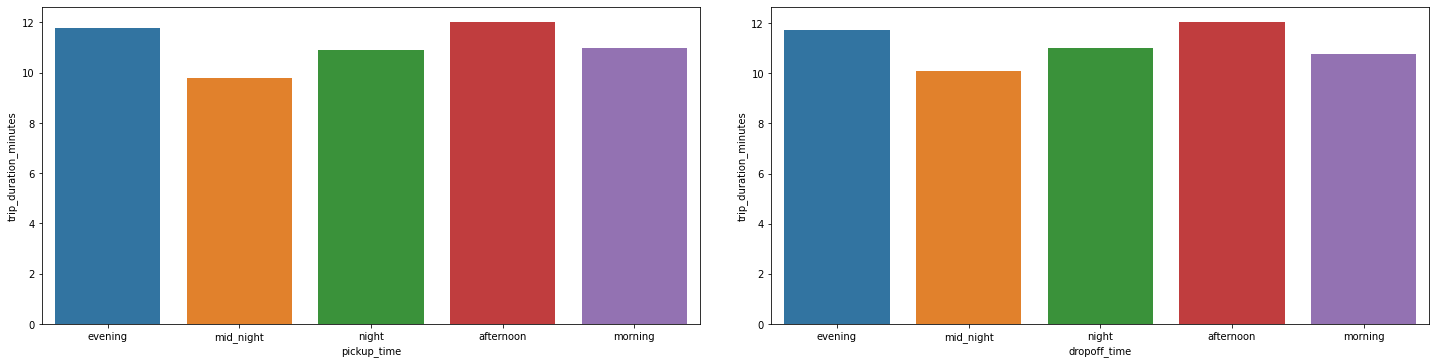

In [ ]:
# Plot it.
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
fig.tight_layout(h_pad=4, w_pad=4)
sns.barplot(data=nyc_df, x='pickup_time', y='trip_duration_minutes', ax=ax1, ci=None)
sns.barplot(data=nyc_df, x='dropoff_time', y='trip_duration_minutes', ax=ax2, ci=None)
plt.show()

* ***most of the pickups and dropoffs happen in the evenings and afternoons, which makes sense as most people comute during these timimgs.***

In [ ]:
# Now lets get dummies for these variables.
nyc_df = pd.get_dummies(nyc_df, columns=['pickup_time', 'dropoff_time'])

In [ ]:
nyc_df.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_hour,dropoff_hour,trip_duration_minutes,distance,store_and_fwd_flag_Y,day_0,day_1,day_2,day_3,day_4,day_5,day_6,month_1,month_2,month_3,month_4,month_5,month_6,pickup_time_afternoon,pickup_time_evening,pickup_time_mid_night,pickup_time_morning,pickup_time_night,dropoff_time_afternoon,dropoff_time_evening,dropoff_time_mid_night,dropoff_time_morning,dropoff_time_night
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,17,17,7.583333,1.498523,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,0,0,11.050000,1.805510,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,19,19,7.150000,1.485500,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,13,13,7.250000,1.188590,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
5,id0801584,2,6,-73.982857,40.742195,-73.992081,40.749184,22,22,7.383333,1.098944,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


***Now than we are done with the cleaning as well as the feature engineering of our data lets do some feature selection before proceeding with the model building.***

# **Feature Selection.**

In [ ]:
# Lets drop id before going further as its not useful.
nyc_df.drop('id', inplace=True, axis=1)

***Split the data first.***

In [ ]:
# Get X and y values.
X = nyc_df.drop('trip_duration_minutes', axis=1)
            
y = nyc_df['trip_duration_minutes']

In [ ]:
# Train Test Split.
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state =5)

In [ ]:
# scale the data.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **Correlation between variables.**

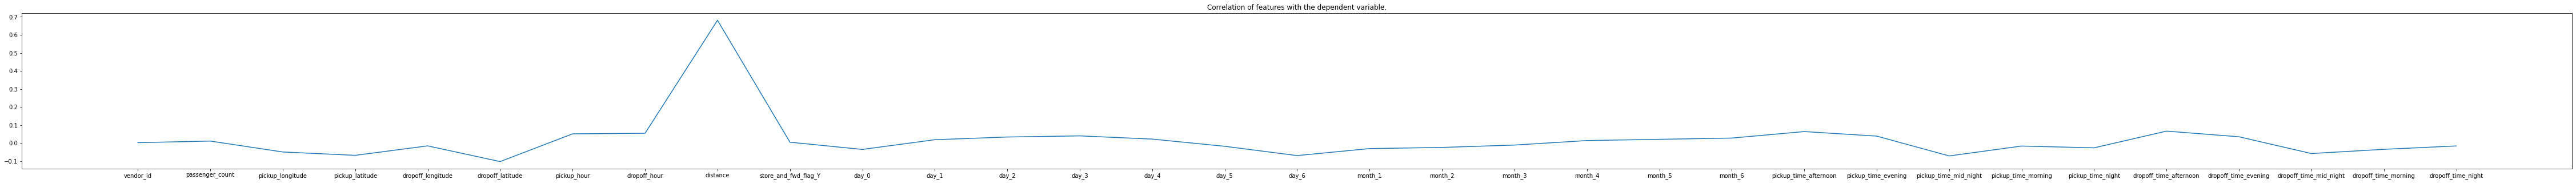

In [ ]:
corr_data = X.corrwith(y)
plt.figure(figsize=(80,5))
plt.plot(corr_data)
plt.title('Correlation of features with the dependent variable.')
plt.show()

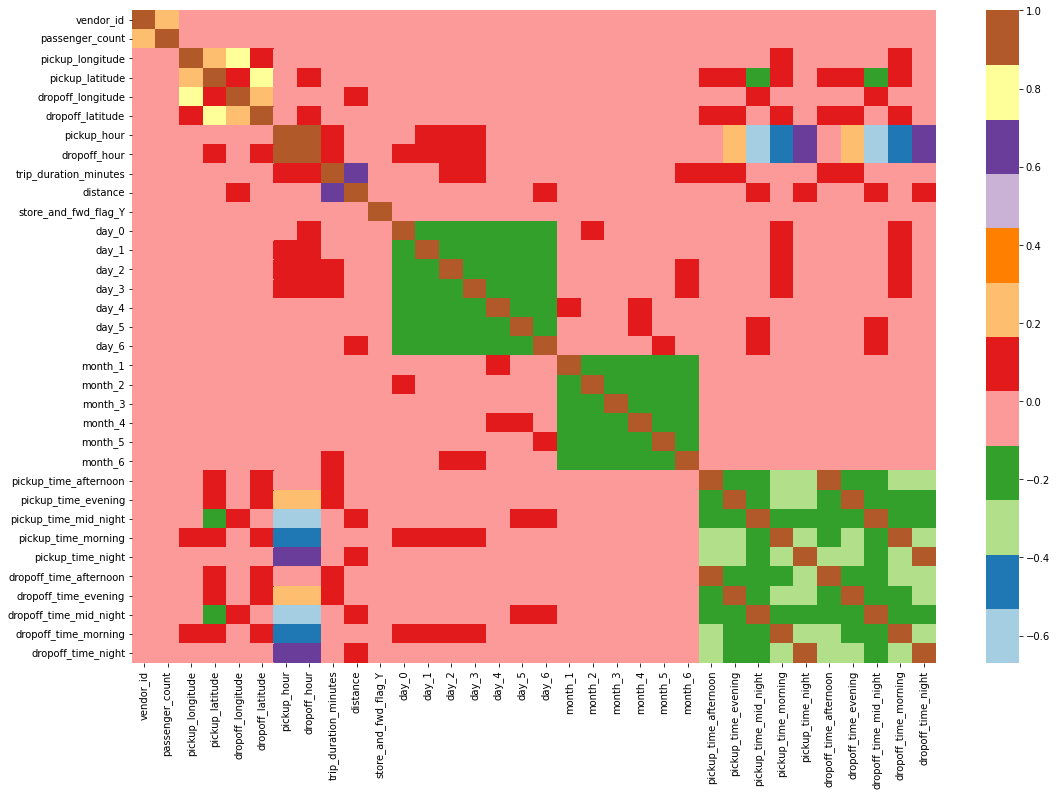

In [ ]:
# Multicollinearity.
fig = plt.figure(figsize=(18,12))
sns.heatmap(nyc_df.corr(), cmap='Paired')
plt.show()

***We will use Lasso from sklearn to select the features that will help in the prediction of our model.***

In [ ]:
feature_sel_model = SelectFromModel(Lasso(alpha=0.05, random_state=5))   # We will use SelectFromModel to select the best features from the data.

# Fit the data.
feature_sel_model.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.05, random_state=5))

In [ ]:
selected_features = X.columns[(feature_sel_model.get_support())]

In [ ]:
selected_features

Index(['passenger_count', 'pickup_longitude', 'dropoff_longitude',
       'dropoff_latitude', 'pickup_hour', 'dropoff_hour', 'distance', 'day_0',
       'day_2', 'day_3', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'pickup_time_mid_night',
       'pickup_time_night', 'dropoff_time_afternoon', 'dropoff_time_morning'],
      dtype='object')

In [ ]:
X_lasso = X[selected_features]
# y values have not changed.

# Do the train test split again with the lasso data for x.
X_train_lasso, X_test_lasso, y_train, y_test = train_test_split(X_lasso, y,test_size=0.2,random_state =5)

# **Model Selection.**

***We will be using few regression models to get the model with best score and minimum error.***

## **Linear Regression.**

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train_lasso, y_train)

In [ ]:
reg.score(X_train_lasso, y_train)

0.5212785765873718

In [ ]:
y_pred_train = reg.predict(X_train_lasso)

In [ ]:
y_pred_test = reg.predict(X_test_lasso)

In [ ]:
#Train set metrics
Ltr_MSE  = mean_squared_error((y_train), (y_pred_train))
print("MSE :" , Ltr_MSE)

Ltr_RMSE = np.sqrt(Ltr_MSE)

print("RMSE :" ,Ltr_RMSE)

Ltr_r2 = r2_score((y_train), (y_pred_train))
print("R2 :" ,Ltr_r2)
Ltr_ar2 = 1-(1-r2_score((y_train), (y_pred_train)))*((X_train_lasso.shape[0]-1)/(X_train_lasso.shape[0]-X_train_lasso.shape[1]-1))
print("Adjusted R2 : ",Ltr_ar2)

MSE : 21.062435433091217
RMSE : 4.589382903298788
R2 : 0.5212785765873718
Adjusted R2 :  0.5212682645077223


In [ ]:
#Test set metrics
Lte_MSE  = mean_squared_error((y_test), (y_pred_test))
print("MSE :" , Lte_MSE)

Lte_RMSE = np.sqrt(Lte_MSE)
print("RMSE :" ,Lte_RMSE)

Lte_r2 = r2_score((y_test), (y_pred_test))
print("R2 :" ,Lte_r2)
Lte_ar2 = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test_lasso.shape[0]-1)/(X_test_lasso.shape[0]-X_test_lasso.shape[1]-1))
print("Adjusted R2 : ",Lte_ar2)

MSE : 21.154858383503203
RMSE : 4.599441094687832
R2 : 0.5223983290044936
Adjusted R2 :  0.5223571745081835


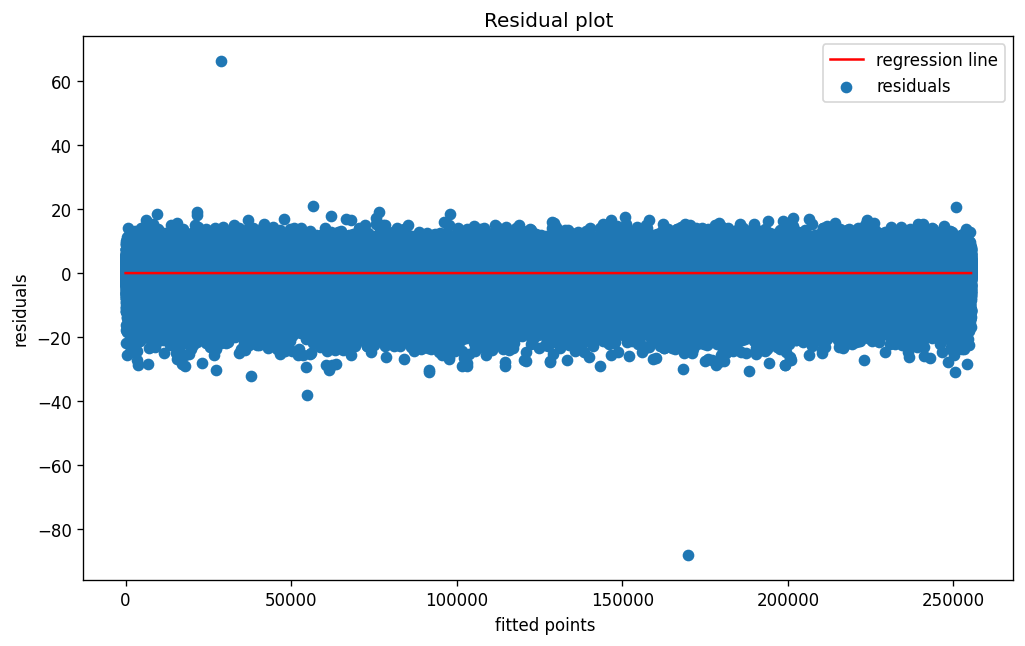

In [ ]:
#Heteroskedasticity
residuals=y_pred_test-y_test

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(y_test))
k = [0 for i in range(0,len(y_test))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()
plt.show()

## **Decision Tree Regressor.**

In [ ]:
# Maximum depth of trees
max_depth = [4,6,8,10]

# Minimum number of samples required to split a node
min_samples_split = [10,20,30]

# Minimum number of samples required at each leaf node
min_samples_leaf = [10,16,20]

# HYperparameter Grid
param_dt = {
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
dt_model = DecisionTreeRegressor()

# Grid search
dt_grid = GridSearchCV(estimator=dt_model,
                       param_grid = param_dt,
                       cv = 5, verbose=2, scoring='r2')

dt_grid.fit(X_train_lasso,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=10; total time=   3.4s
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=10; total time=   3.3s
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=10; total time=   3.3s
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=10; total time=   3.3s
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=10; total time=   3.2s
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=20; total time=   3.3s
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=20; total time=   3.3s
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=20; total time=   3.3s
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=20; total time=   3.3s
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=20; total time=   3.3s
[CV] END max_depth=4, min_samples_leaf=10, min_samples_split=30; total time=   3.3s
[CV] END max_d

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [10, 16, 20],
                         'min_samples_split': [10, 20, 30]},
             scoring='r2', verbose=2)

In [ ]:
dt_optimal_model =dt_grid.best_estimator_
y_pred_dt_test=dt_optimal_model.predict(X_test_lasso)
y_pred_dt_train=dt_optimal_model.predict(X_train_lasso)

In [ ]:
# dt Train scores.
MSE  = mean_squared_error(y_train, y_pred_dt_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_dt_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score(y_train, y_pred_dt_train))*((X_train_lasso.shape[0]-1)/(X_train_lasso.shape[0]-X_train_lasso.shape[1]-1)))

Train MSE : 16.9570225839009
Train RMSE : 4.1178905502576075
Train R2 : 0.6145892048432628
Train Adjusted R2 :  0.6145809027564477


In [ ]:
# dt Test scores.
MSE  = mean_squared_error(y_test, y_pred_dt_test)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_dt_test)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score(y_test, y_pred_dt_test))*((X_test_lasso.shape[0]-1)/(X_test_lasso.shape[0]-X_test_lasso.shape[1]-1)))

Test MSE : 17.24201833782454
Test RMSE : 4.152350941072363
Test R2 : 0.6107363793131432
Test Adjusted R2 :  0.6107028368253042


## **Extra Tree Regressor.**

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor()

In [ ]:
# # Hyperparameters for extra trees regressor.
#     # 'min_samples_leaf': [1,2]
# param_etr = {
#     'max_depth': [2,8,16,32],
#     'min_samples_split': [2,4,6]}

In [ ]:
# Train the model.
etr_reg = ExtraTreesRegressor(max_depth=32, min_samples_split=6, min_samples_leaf=1, random_state=0).fit(X_train_lasso, y_train)

# Grid search
# etr_grid = GridSearchCV(estimator=etr,
#                        param_grid = param_etr,
#                        cv = 2, verbose=2, scoring='r2')

# etr_grid.fit(X_train_lasso,y_train)

In [ ]:
# etr_grid.best_params_

{'max_depth': 32, 'min_samples_split': 6}

In [ ]:
# etr_grid.best_estimator_

ExtraTreesRegressor(max_depth=32, min_samples_split=6)

In [ ]:
# # Optimum model
# etr_optimal_model =etr_grid.best_estimator_

# # Train preds.
# y_pred_etr_train=etr_optimal_model.predict(X_train_lasso)

# # Test preds.
# y_pred_etr_test=etr_optimal_model.predict(X_test_lasso)

In [ ]:
# Train preds.
y_pred_etr_train = etr_reg.predict(X_train_lasso)
# Test preds.
y_pred_etr_test = etr_reg.predict(X_test_lasso)

In [ ]:
# Train scores.
# dt Train scores.
MSE  = mean_squared_error(y_train, y_pred_etr_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_etr_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score(y_train, y_pred_etr_train))*((X_train_lasso.shape[0]-1)/(X_train_lasso.shape[0]-X_train_lasso.shape[1]-1)))

Train MSE : 2.347927433191447
Train RMSE : 1.5322948258058717
Train R2 : 0.9466347010791998
Train Adjusted R2 :  0.9466335515438206


In [ ]:
# Test scores.
MSE  = mean_squared_error(y_test, y_pred_etr_test)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_etr_test)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score(y_test, y_pred_etr_test))*((X_test_lasso.shape[0]-1)/(X_test_lasso.shape[0]-X_test_lasso.shape[1]-1)))

Test MSE : 14.067751101084026
Test RMSE : 3.750700081462663
Test R2 : 0.6824000751399033
Test Adjusted R2 :  0.6823727078467603


## **XGBoost.**

In [ ]:
# Hyperparameters for xgb.
n_estimators = [50,100,120]
max_depth = [5,7,9]
min_samples_split = [40,50]


# HYperparameter Grid
param_xgb = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
             'min_samples_split':min_samples_split
              }

In [ ]:
# Create an instance of the  XGBRegressor
import xgboost as xgb
xgb_model = xgb.XGBRegressor()

# Grid search
xgb_grid = GridSearchCV(estimator=xgb_model,param_grid = param_xgb,cv = 3, verbose=2,scoring="r2")

xgb_grid.fit(X_train_lasso,y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[08:33:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .max_depth=5, min_samples_split=40, n_estimators=50; total time=  50.3s
[08:34:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .max_depth=5, min_samples_split=40, n_estimators=50; total time=  51.8s
[08:35:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END .max_depth=5, min_samples_split=40, n_estimators=50; total time=  51.7s
[08:36:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] END max_depth=5, min_samples_split=40, n_estimators=100; total time= 1.7min
[08:37:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor o

GridSearchCV(cv=3, estimator=XGBRegressor(),
             param_grid={'max_depth': [5, 7, 9], 'min_samples_split': [40, 50],
                         'n_estimators': [50, 100, 120]},
             scoring='r2', verbose=2)

In [ ]:
xgb_grid.best_score_

0.7062813231063263

In [ ]:
xgb_grid.best_params_

{'max_depth': 9, 'min_samples_split': 40, 'n_estimators': 120}

In [ ]:
xgb_optimal_model =xgb_grid.best_estimator_

In [ ]:
y_pred_xgb_test=xgb_optimal_model.predict(X_test_lasso)
y_pred_xgb_train=xgb_optimal_model.predict(X_train_lasso)

In [ ]:
# Train scores.
MSE  = mean_squared_error(y_train, y_pred_xgb_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_xgb_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score((y_train), (y_pred_xgb_train)))*((X_train_lasso.shape[0]-1)/(X_train_lasso.shape[0]-X_train_lasso.shape[1]-1)))

Train MSE : 11.956331939101862
Train RMSE : 3.4577929288929177
Train R2 : 0.7282483185354662
Train Adjusted R2 :  0.7282424647657224


In [ ]:
# Test scores.
MSE  = mean_squared_error(y_test, y_pred_xgb_test)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_xgb_test)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score((y_test), (y_pred_xgb_test)))*((X_test_lasso.shape[0]-1)/(X_test_lasso.shape[0]-X_test_lasso.shape[1]-1)))

Test MSE : 12.86291181539408
Test RMSE : 3.5864901805796263
Test R2 : 0.7096010729293888
Test Adjusted R2 :  0.709576049521184


## **Gradient Boosting**

In [ ]:
# Create an instance of the  GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
gb_model=GradientBoostingRegressor( n_estimators=120, max_depth=10, min_samples_leaf=50, min_samples_split=80)

# Train the model.
gb_model.fit(X_train_lasso,y_train)

GradientBoostingRegressor(max_depth=10, min_samples_leaf=50,
                          min_samples_split=80, n_estimators=120)

In [ ]:
# gb_grid.best_params_

In [ ]:
# gb_grid.best_estimator_

In [ ]:
# gb_optimal_model = gb_grid.best_estimator_

In [ ]:
y_preds_gb = gb_model.predict(X_test_lasso)
y_pred_gb_train=gb_model.predict(X_train_lasso)

In [ ]:
# Train Scores.
MSE  = mean_squared_error(y_train, y_pred_gb_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_gb_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score((y_train), (y_pred_gb_train)))*((X_train_lasso.shape[0]-1)/(X_train_lasso.shape[0]-X_train_lasso.shape[1]-1)))

Train MSE : 11.690737170543489
Train RMSE : 3.419172000725247
Train R2 : 0.7342849379026384
Train Adjusted R2 :  0.7342792141669742


In [ ]:
# Test Scores.
MSE  = mean_squared_error(y_test, y_preds_gb)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_preds_gb)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score((y_test), (y_preds_gb)))*((X_test_lasso.shape[0]-1)/(X_test_lasso.shape[0]-X_test_lasso.shape[1]-1)))

Test MSE : 12.64055002188719
Test RMSE : 3.5553551189560784
Test R2 : 0.7146212135618245
Test Adjusted R2 :  0.7145966227345166
